In [1]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import pytorch_lightning as pl
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting import TimeSeriesDataSet, Baseline, NHiTS, GroupNormalizer, MultiNormalizer, EncoderNormalizer

In [3]:
DATA_PATH = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/electricity/electricity.csv"

EPOCHS = 1
VAL_PERC = .2
TEST_PERC = .1
BATCH_SIZE = 32

LAG_TIME = 336
LEAD_TIME = 168

## Load  Data

In [4]:
df = pd.read_csv(DATA_PATH, index_col=0)
df = df.iloc[:, :-1]
df.index = pd.to_datetime(df.index)
df = df.reset_index().rename({'index':'date'}, axis=1)
df

,date,0,1,2,3,4,5,6,7,8,...,310,311,312,313,314,315,316,317,318,319
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,199.0,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,265.0,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,278.0,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,271.0,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,267.0,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,178.0,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0
26300,2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,241.0,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0
26301,2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,158.0,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0
26302,2019-07-02 00:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,120.0,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0


In [5]:
# reduce dataste
#df = df.iloc[:, :12]

In [6]:
n_samples = len(df)
n_val = int(n_samples * VAL_PERC)
n_test = int(n_samples * TEST_PERC)
n_train = n_samples - (n_val + n_test)

# Split data into train and test
train_df = df.iloc[:n_train, :]
val_df = df.iloc[n_train:n_train+n_val]
test_df = df.iloc[n_train+n_val:]

In [7]:
# Rename index to time_idx
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
val_df = val_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
val_df['group_ids'] = 0
test_df['group_ids'] = 0

In [8]:
# Reshape data into single value column that is uniquely indexed by pairs of (time_idx, group_ids).
train_df = train_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
val_df = val_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
test_df = test_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')

## Data Definition

In [9]:
# Define datasets
train_data = TimeSeriesDataSet(
    data=train_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

val_data = TimeSeriesDataSet(
    data=val_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(val_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

test_data = TimeSeriesDataSet(
    data=test_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(test_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

In [10]:
# Define dataloader
train_dataloader = train_data.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = val_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)
test_dataloader = test_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)

## Model Definition

In [11]:
# Init model with structure specified in dataset
net = NHiTS.from_dataset(
    train_data,
    learning_rate=1e-4,
    weight_decay=1e-2
)

## Training and Validation

In [12]:
# Set random seed 
pl.seed_everything(42)

# Define early stopping criteria
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=1,
    weights_summary="top",
    callbacks=[early_stop_callback],
    limit_train_batches=.2,
    limit_val_batches=.2,
)


# Train and Validate Model
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | MASE           | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 1.6 M 
---------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.374     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
# Load best model from checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

## Test

In [14]:
# Get predictions from test dataset
preds, x = best_model.predict(test_dataloader, return_x=True)

In [16]:
# Aggregate inputs, ground truth and classes into tensor alligned with predictions
input_list, true_list, class_list = [], [], []
for x, y in test_dataloader: 
    input_list.append(x["encoder_target"])
    true_list.append(y[0])
    class_list.append(x["groups"])


inputs = torch.cat(input_list)
trues = torch.cat(true_list)
classes = torch.cat(class_list)

print(inputs.shape, preds.shape, trues.shape, classes.shape)

torch.Size([23397, 336]) torch.Size([23397, 168]) torch.Size([23397, 168]) torch.Size([23397, 1])


In [17]:
# Select indices of samples to visualize
n_samples = 10
ss_indices = np.random.choice(range(preds.shape[0]), n_samples, replace=False)
ss_pred = preds[ss_indices]
ss_true = trues[ss_indices]
ss_input = inputs[ss_indices]
ss_class = classes[ss_indices]

print(ss_input.shape, ss_pred.shape, ss_true.shape, ss_class.shape)

torch.Size([10, 336]) torch.Size([10, 168]) torch.Size([10, 168]) torch.Size([10, 1])


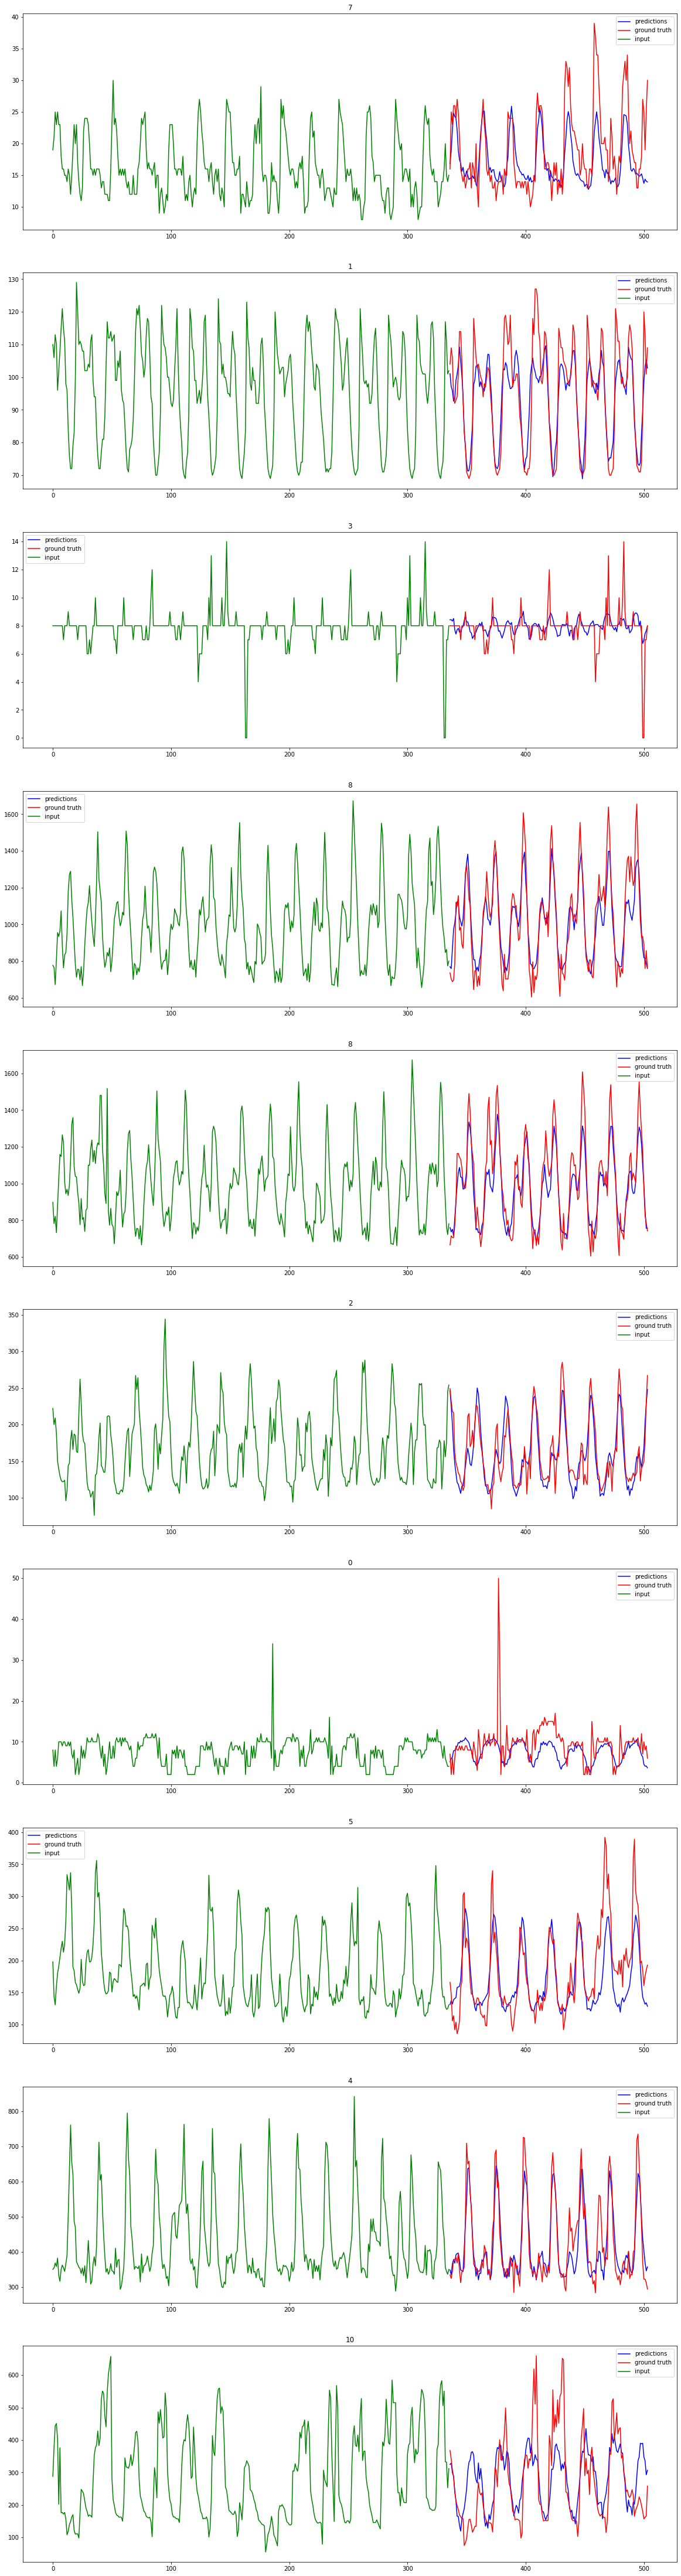

In [18]:
# Loop through samples and plot input, ground truth and prediction
f, axarr = plt.subplots(n_samples, 1, figsize=(20, 80))
for i in range(n_samples):
    series_preds = ss_pred[i, :].squeeze()
    series_trues = ss_true[i, :].squeeze()
    series_inputs = ss_input[i, :].squeeze()

    feat_name = str(ss_class[i].item())
    
    input_len = series_inputs.shape[0]
    pred_gt_len = series_preds.shape[0]
    input_x = np.array([i for i in range(input_len)])
    x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
    axarr[i].plot(x, series_preds, c="blue", label="predictions")
    axarr[i].plot(x, series_trues, c="red", label="ground truth")
    axarr[i].plot(input_x, series_inputs, c="green", label="input")
    axarr[i].legend()
    axarr[i].set_title(feat_name)

In [19]:
# Calculate losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 4243.54443359375 MAE: 35.30398941040039
